In [1]:
import json
import numpy as np
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from shapely import geometry
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from utils.utils import load_sfkb ,get_image_ids, utm_to_image, transform_utm_buildings, dump_building_objects, shrink_polygon
import os
import PIL
import sys
from cv2 import resize
import cogdumper

buildings = load_sfkb(max_buildings=1000)
buildings = get_image_ids(buildings)
buildings = transform_utm_buildings(buildings)
dump_building_objects(buildings, '../results/building_objects')
with open('../results/image_to_building_pointers.pickle', 'rb') as file:
    pointers = pickle.load(file)

In [3]:
def dump_cutouts(ap_ids, nudge=np.array((13,20)), pad=15):

    with open('../results/image_to_building_pointers.pickle', 'rb') as file:
        pointers = pickle.load(file)   

    for ap_id in ap_ids:
        aerial_photo = plt.imread(f'../data/aerial_photos/RGB/{ap_id}.tif')

        for i, building_id in enumerate(pointers[ap_id]):
            try:
                with open(f'../results/building_objects/{building_id}.pickle', 'rb') as file:
                    building = pickle.load(file)
                    
                if  building.image_ids.index(ap_id) != 0:
                    corners = building.image_corners[building.image_ids.index(ap_id)-1]


                    loc_min = np.min(corners, axis=0).astype(int) 
                    loc_max = np.max(corners, axis=0).astype(int)
                    
                    x_ext, y_ext = loc_max[0]-loc_min[0], loc_max[1]-loc_min[1]

                    if x_ext > y_ext: # Pad shortest axis
                        sq_pad = np.array((0, (x_ext-y_ext)/2)).astype(int)
                    else:
                        sq_pad = np.array(((y_ext-x_ext)/2, 0)).astype(int)

                    graph_cutout = np.empty(corners.shape)
                    
                    if x_ext != 0 and y_ext != 0:
                        graph_cutout = (corners.T-loc_min.reshape(-1, 1)+pad+nudge.reshape(-1, 1) + sq_pad.reshape(-1, 1)).T # transform graph to cutout frame 
                    building.cutout_corners[building.image_ids.index(ap_id)-1] = graph_cutout 

                    im =  aerial_photo[loc_min[1]-pad-sq_pad[1]:loc_max[1]+2*pad +sq_pad[1]+ nudge[1], loc_min[0]-pad - sq_pad[0]:loc_max[0]+2*pad + nudge[0]+sq_pad[0]] # crop cutout
                    
                    cutout_path = '../results/cutouts'
                    if not os.path.exists(cutout_path):
                        os.makedirs(cutout_path)

                    try: # Skips a building representation if any part is outside the image
                        plt.imsave(f'{cutout_path}/{building_id}_{ap_id}.png', im)

                        with open(f'../results/building_objects/{building_id}.pickle', 'wb') as handle:
                            pickle.dump(building, handle)
                    except (SystemError):
                        pass
            except (FileNotFoundError):
                pass                

        print(f'image {ap_id} done')
dump_cutouts(list(pointers.keys()))

image 14525_01_001_00001 done
image 14525_01_002_00002 done
image 14525_01_003_00003 done
image 14525_01_004_00004 done
image 14525_01_005_00005 done
image 14525_01_006_00006 done
image 14525_01_007_00007 done
image 14525_01_008_00008 done
image 14525_01_009_00009 done
image 14525_01_010_00010 done
image 14525_01_011_00011 done
image 14525_01_012_00012 done
image 14525_01_013_00013 done
image 14525_01_014_00014 done
image 14525_01_015_00015 done
image 14525_01_016_00016 done
image 14525_01_017_00017 done
image 14525_01_018_00018 done
image 14525_01_019_00019 done
image 14525_01_020_00020 done
image 14525_01_021_00021 done
image 14525_01_022_00022 done
image 14525_01_023_00023 done
image 14525_01_024_00024 done
image 14525_01_025_00025 done
image 14525_01_026_00026 done
image 14525_01_027_00027 done
image 14525_01_028_00028 done
image 14525_01_029_00029 done
image 14525_01_030_00030 done
image 14525_01_031_00031 done
image 14525_01_032_00032 done
image 14525_01_033_00033 done
image 1452

FileNotFoundError: [Errno 2] No such file or directory: '../data/aerial_photos/RGB/14525_04_001_00151.tif'

In [10]:
import glob


glob.glob('../results/cutouts/21464*')

['../results/cutouts\\21464_14525_03_019_00123.png',
 '../results/cutouts\\21464_14525_03_020_00124.png',
 '../results/cutouts\\21464_14525_03_021_00125.png',
 '../results/cutouts\\21464_14525_03_022_00126.png',
 '../results/cutouts\\21464_14525_04_004_00148.png',
 '../results/cutouts\\21464_14525_04_005_00147.png',
 '../results/cutouts\\21464_14525_04_006_00146.png',
 '../results/cutouts\\21464_14525_04_007_00145.png',
 '../results/cutouts\\21464_14525_04_008_00144.png']

14525_04_012_00140 11493_14525_04_012_00140.png
14525_04_012_00140 11884_14525_04_012_00140.png
14525_04_012_00140 12432_14525_04_012_00140.png
14525_04_012_00140 12789_14525_04_012_00140.png
14525_04_012_00140 13019_14525_04_012_00140.png
14525_04_012_00140 13661_14525_04_012_00140.png
14525_04_012_00140 14365_14525_04_012_00140.png
14525_04_012_00140 15569_14525_04_012_00140.png
14525_04_012_00140 15953_14525_04_012_00140.png
14525_04_012_00140 16610_14525_04_012_00140.png
14525_04_012_00140 16750_14525_04_012_00140.png


IndexError: index 10 is out of bounds for axis 0 with size 10

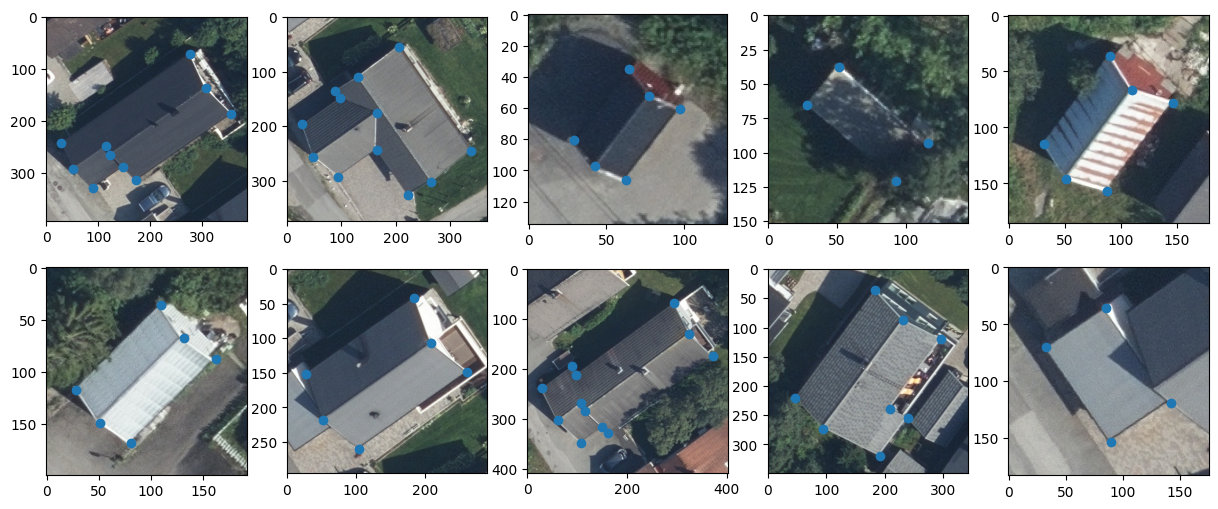

In [6]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, name in enumerate(os.listdir('../results/cutouts')):
     

    building_id = name.split('_')[0]
    image_id = '_'.join(name.split('_')[1:]).split('.')[0]

    print(image_id, name)
    with open( f'../results/building_objects/{building_id}.pickle', 'rb') as object:
        building = pickle.load(object)
        
    axs.flatten()[i].scatter(*building.cutout_corners[building.image_ids.index(image_id)-1].T)
    axs.flatten()[i].imshow(plt.imread(f'../results/cutouts/{name}'))

    #axs.flatten()[i].

def plot_cutouts(building_id):
    for file in glob.glob(f'../results/cutouts/{building_id}*'):
        




    

